In [ ]:
#Source https://medium.com/intel-student-ambassadors/mnist-gan-detailed-step-by-step-explanation-implementation-in-code-ecc93b22dc60

#https://github.com/lyeoni/pytorch-mnist-GAN/blob/master/pytorch-mnist-GAN.ipynb

# Sebastian's GAN example uses quite a few helper functions. This code is as close as to what we've done so far

#Example of a simple GAN

In this example, the Discriminator and Generator components are both fully connected layers regularized by Dropout. In many architectures today, Convolution based GANs such as Deep Convolution GANs (DCGANs) are more popular.



### 1. Dependencies, datasets, dataloaders.

In [ ]:

# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batchSize = 100

#I'm using the transform that we've been using so far in the course as opposed to what the original sources are using
transform = transforms.Compose([
                                transforms.ToTensor(), #this convert to tensor
                                transforms.Lambda(lambda x:x.view(-1))  #this flatten 28*28 into a 784 vector for each image
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)


### 2. Define Discriminator and Generator Networks

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2) #512
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2) #1024
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim) #784
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))


## 3. Define functions for training Disciminator and Generator

Pay attention to how the losses are defined. 

In [ ]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # 1. Train discriminator to identify real images as real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(batchSize, 1)  #torch.ones, to set labels of real images as true
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # 2. Train discriminator to identify fake images as fakes
    z = Variable(torch.randn(batchSize, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(batchSize, 1).to(device)) #torch.zeros, to set labels of fake images as fakes

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss   #IMPORTANT!!
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()


def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    # 3. Train Generator to generate/identify fake images as real 
    z = Variable(torch.randn(batchSize, z_dim).to(device))
    y = Variable(torch.ones(batchSize, 1).to(device)) #"flipping labels". Labels are supposed to be 0 (fake) but we are labelling as 1 (true)

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()


## 4. Declare model, loss, optimizer

In [ ]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

#The dimensions are set as same as the original GAN paper if I'm correct
G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

# loss
criterion = nn.BCELoss() #Binary Cross Entropy

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)


### 5. Training

As usual, this takes the longest. Change your settings to GPU.

* Train Discriminator to identify real images
* Train Discriminator to identify fake images
* Train Generator to generate fake images that are real 

In [ ]:
n_epoch = 200
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

 

[1/200]: loss_d: 1.331, loss_g: 1.068
[2/200]: loss_d: 1.049, loss_g: 2.003
[3/200]: loss_d: 0.764, loss_g: 2.152
[4/200]: loss_d: 0.720, loss_g: 2.294
[5/200]: loss_d: 0.742, loss_g: 2.209
[6/200]: loss_d: 0.785, loss_g: 1.954
[7/200]: loss_d: 0.783, loss_g: 2.095
[8/200]: loss_d: 0.712, loss_g: 2.210
[9/200]: loss_d: 0.748, loss_g: 2.143
[10/200]: loss_d: 0.766, loss_g: 2.000
[11/200]: loss_d: 0.729, loss_g: 2.033
[12/200]: loss_d: 0.794, loss_g: 2.043
[13/200]: loss_d: 0.765, loss_g: 1.974
[14/200]: loss_d: 0.819, loss_g: 2.136
[15/200]: loss_d: 0.739, loss_g: 2.064
[16/200]: loss_d: 0.786, loss_g: 2.046
[17/200]: loss_d: 0.761, loss_g: 1.954
[18/200]: loss_d: 0.695, loss_g: 2.049
[19/200]: loss_d: 0.729, loss_g: 2.268
[20/200]: loss_d: 0.715, loss_g: 2.141
[21/200]: loss_d: 0.702, loss_g: 2.286
[22/200]: loss_d: 0.700, loss_g: 2.106
[23/200]: loss_d: 0.692, loss_g: 2.166
[24/200]: loss_d: 0.668, loss_g: 2.289
[25/200]: loss_d: 0.642, loss_g: 2.403
[26/200]: loss_d: 0.642, loss_g: 2

### 6. Generate a few images

In [ ]:

with torch.no_grad():
    test_z = Variable(torch.randn(batchSize, z_dim).to(device))
    generated = G(test_z)

image_data = generated.view(generated.size(0),1,28,28)
print(image_data.shape)


torch.Size([100, 1, 28, 28])


### 7. Visualize the generated 'fake-mnist' image

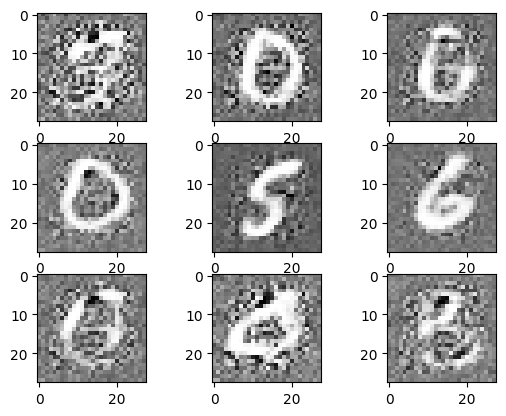

In [ ]:

import matplotlib.pyplot as plt

count=1
for i in range(9):
    imd = image_data[i].view(28,28)
    imd = imd.cpu()

    plt.subplot(3,3,count)
    plt.imshow(imd, cmap=plt.get_cmap('gray'))
    count+=1

plt.show()
  
    
  
